<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_13_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Don't Stop Me Now, or: Hamiltonian Monte Carlo

Most MCMC samplers (e.g. random‑walk Metropolis) suffer from slow exploration in high‑dimensional spaces. [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) augments your target density
$$
\pi(\theta)\propto \exp\bigl(-U(\theta)\bigr)
$$
with an auxiliary “momentum” variable $p$ to explore with (approximately) energy‑conserving trajectories, reducing random‑walk behaviour.


## Hamiltonian dynamics

Define
$$
H(\theta,p) \;=\; U(\theta)\;+\;K(p),
$$
where
- $U(\theta)=-\log\pi(\theta)$ (“potential energy”),  
- $K(p)=\tfrac12\,p^T M^{-1}p$ (“kinetic energy”), and $M$ is a chosen mass matrix (often identity).

Hamilton’s equations give continuous dynamics:
$$
\frac{d\theta}{dt} = \frac{\partial H}{\partial p} = M^{-1}p,
\qquad
\frac{dp}{dt} = -\frac{\partial H}{\partial \theta} = -\nabla U(\theta).
$$
These dynamics are **volume‑preserving** and conserve $H$, so if we could simulate them exactly over time $T$, the joint density
$\exp(-H(\theta,p))$
would be invariant.

![HMC](https://upload.wikimedia.org/wikipedia/commons/f/fa/Hamiltonian_Monte_Carlo.gif "hmc")


## Symplectic integrator: the leapfrog method

We cannot solve Hamilton’s equations in closed form in general, so we use a symplectic (volume‑preserving, reversible) discretization.  With step size $\varepsilon$ and letting $\nabla U(\theta)$ denote the gradient:

1. Half‑step momentum:
   $$
   p_{t + \frac12} \;=\; p_t \;-\;\tfrac{\varepsilon}{2}\,\nabla U(\theta_t),
   $$
2. Full‑step position:
   $$
   \theta_{t+1} \;=\; \theta_t \;+\;\varepsilon\,M^{-1}p_{t + \frac12},
   $$
3. Half‑step momentum:
   $$
   p_{t+1} \;=\; p_{t + \frac12} \;-\;\tfrac{\varepsilon}{2}\,\nabla U(\theta_{t+1}).
   $$

This integrator is reversible and approximately conserves $H$ up to $O(\varepsilon^2)$.

## The HMC algorithm

Putting it all together, one HMC iteration from current state $\theta$ is:

1. **Sample** a fresh momentum  
   $\displaystyle p\sim\mathcal N(0,\,M)$.
2. **Simulate** $L$ leapfrog steps of size $\varepsilon$ to propose $(\theta^*, p^*)$.
3. **Negate** momentum (makes proposal reversible): $p^*\leftarrow -p^*$.
4. **Metropolis accept/reject** with probability
   $$
   \alpha = \min\!\Bigl(1,\;\exp\bigl[-H(\theta^*,p^*) + H(\theta,p)\bigr]\Bigr).
   $$
   If accepted, set $\theta\leftarrow\theta^*$, else keep the old $\theta$.
5. **Discard** $p$ and repeat.

Key tuning parameters:
- Step size $\varepsilon$ (too large → low acceptance;
  too small → slow exploration).
- Number of steps $L$ (longer trajectories explore farther but cost more).




## Implementing HMC in JAX via BlackJAX

We’ll demonstrate on a two‑dimensional “banana” target,
$$
\pi(x,y)\propto
\exp\!\Bigl[-\bigl(x^2/2 + (y + 0.03\,x^2 - 3)^2/2\bigr)\Bigr].
$$

In [1]:
!pip install blackjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 10.3 MB/s eta 0:00:00


Acceptance rate: 1.0


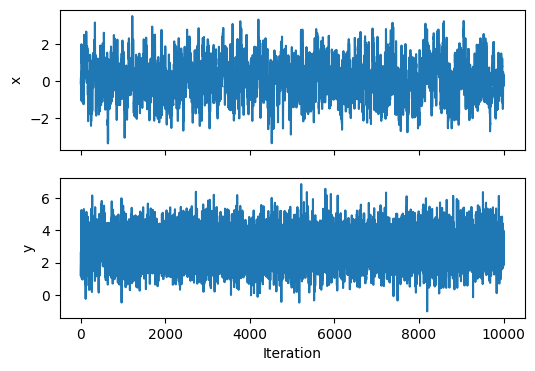

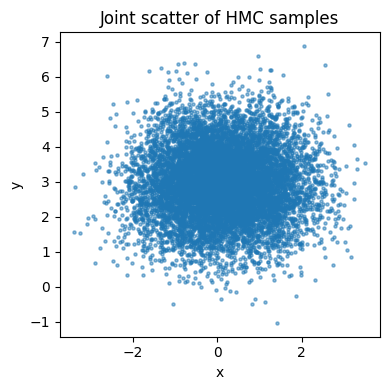

In [44]:
import jax
import jax.numpy as jnp
import blackjax

# 1. Define log‑density and gradient
def logprob(z):
    x, y = z[..., 0], z[..., 1]
    return -0.5*(x**2 + (y + 0.03*x**2 - 3)**2)

# 2. Set up HMC kernel (identity mass)
step_size = 0.001
num_steps = 500
Minv = jnp.array([[1.0, 0.5], [0.5, 100.0]])
hmc = blackjax.hmc(logprob, step_size, Minv, num_steps)

# 3. Initialize
key = jax.random.PRNGKey(10)
init_position = jnp.array([0.0, 0.0])
state = hmc.init(init_position)

# 4. Run a chain
@jax.jit
def one_step(state, key):
    key, subkey = jax.random.split(key)
    state, info = hmc.step(subkey, state)
    return state, (state.position, info.is_accepted)

num_samples = 10_000
keys = jax.random.split(key, num_samples)
states, (positions, accept) = jax.lax.scan(one_step, state, keys)

positions = jnp.stack(positions)  # shape (num_samples, 2)
accept_rate = accept.mean()

print("Acceptance rate:", accept_rate)
import matplotlib.pyplot as plt

# Trace plots
fig, axes = plt.subplots(2,1, figsize=(6,4), sharex=True)
axes[0].plot(positions[:,0]); axes[0].set_ylabel("x")
axes[1].plot(positions[:,1]); axes[1].set_ylabel("y")
axes[1].set_xlabel("Iteration")

# Scatter of samples
plt.figure(figsize=(4,4))
plt.scatter(positions[:,0], positions[:,1], s=5, alpha=0.5)
plt.title("Joint scatter of HMC samples")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()

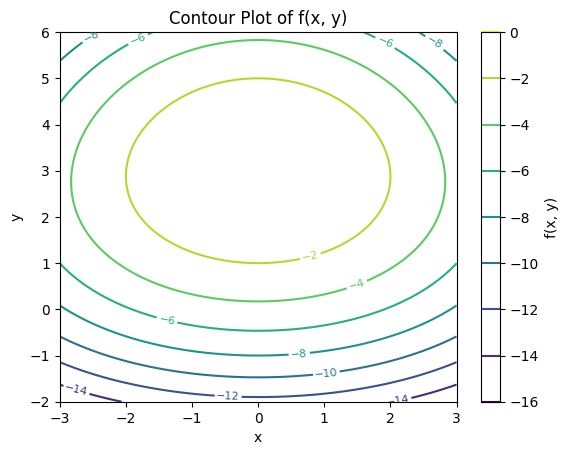

In [38]:
import matplotlib.pyplot as plt

def logprob(x, y):
    return -0.5*(x**2 + (y + 0.03*x**2 - 3)**2)

x = jnp.linspace(-3, 3, 1_000)
y = jnp.linspace(-2, 6, 1_000)
x, y = jnp.meshgrid(x, y)
Z = logprob(x, y)
# Plot the contour
plt.figure()
CS = plt.contour(x, y, Z)  # default contour
plt.clabel(CS, inline=True, fontsize=8)
plt.title('Contour Plot of f(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='f(x, y)')
plt.show()

## 7 – Exercises

1. **Tuning step size.** Try $\varepsilon=0.05,0.2$. How does the acceptance rate and effective sample size change?
2. **Changing trajectory length.** Fix $\varepsilon=0.1$. Try $L=5,50$. What is the trade‑off?
3. **Mass matrix.** Implement a diagonal mass matrix $M=\mathrm{diag}(1,\,10)$. How does sampling improve?
4. **Apply to logistic regression.** Replace the banana target with a Bayesian logistic‐regression posterior on a real or synthetic dataset. Compare to a random‑walk Metropolis baseline.
5. **Extension (NUTS).** Study the No‑U‑Turn Sampler: how does it choose $L$ automatically? Try BlackJAX’s `blackjax.nuts`.


Acceptance rate: 0.993973


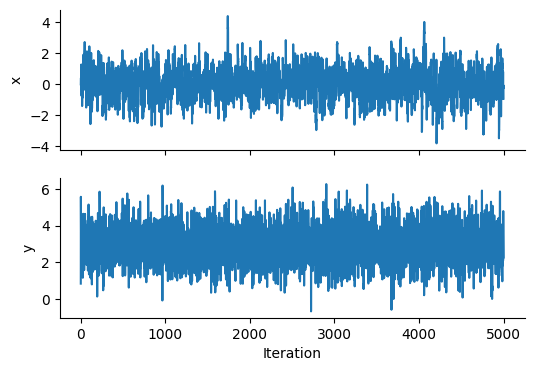

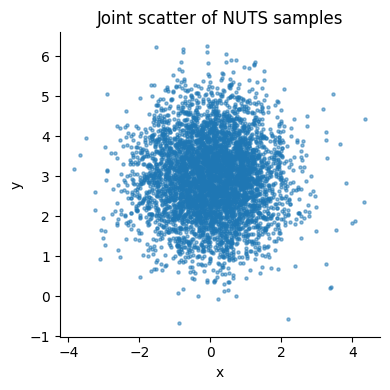

In [56]:
import jax

# 1. Define log‑density and gradient
def logprob(z):
    x, y = z[..., 0], z[..., 1]
    return -0.5*(x**2 + (y + 0.03*x**2 - 3)**2)

# 2. Set up HMC kernel (identity mass)
step_size = 0.1
num_steps = 500
Minv = jnp.array([[1.0, 0.5], [0.5, 10.0]])

nuts = blackjax.nuts(logprob, step_size, Minv)

# 3. Initialize
key = jax.random.PRNGKey(10)
init_position = jnp.array([0.0, 0.0])
state = nuts.init(init_position)

# 4. Run a chain
@jax.jit
def one_step(state, key):
    key, subkey = jax.random.split(key)
    state, info = nuts.step(subkey, state)
    return state, (state.position, info.acceptance_rate)

num_samples = 5_000
keys = jax.random.split(key, num_samples)
states, (positions, accept_rate) = jax.lax.scan(one_step, state, keys)

positions = jnp.stack(positions)  # shape (num_samples, 2)
accept_rate = accept_rate.mean()

print("Acceptance rate:", accept_rate)
import matplotlib.pyplot as plt

# Trace plots
fig, axes = plt.subplots(2,1, figsize=(6,4), sharex=True)
axes[0].plot(positions[:,0]); axes[0].set_ylabel("x")
axes[1].plot(positions[:,1]); axes[1].set_ylabel("y")
axes[1].set_xlabel("Iteration")

# Scatter of samples
plt.figure(figsize=(4,4))
plt.scatter(positions[:,0], positions[:,1], s=5, alpha=0.5)
plt.title("Joint scatter of NUTS samples")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()

## Bayesian Logistic Regression

[todo]



Acceptance rate: 0.9915218
[[0.16016255 0.16666071]
 [0.703684   0.8296122 ]
 [0.6978764  0.7003871 ]
 ...
 [0.52012527 0.6615875 ]
 [0.5161623  0.6437484 ]
 [0.6495578  0.58312565]]


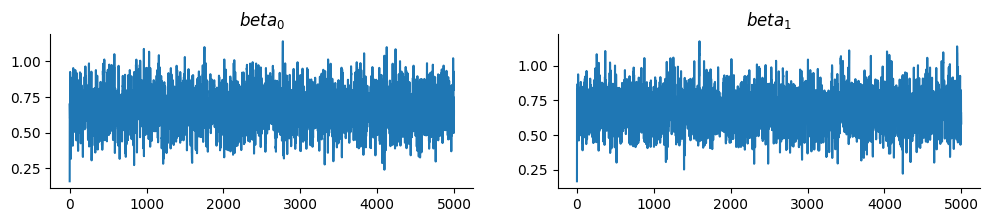

(2, 61, 59)
(5000, 2)


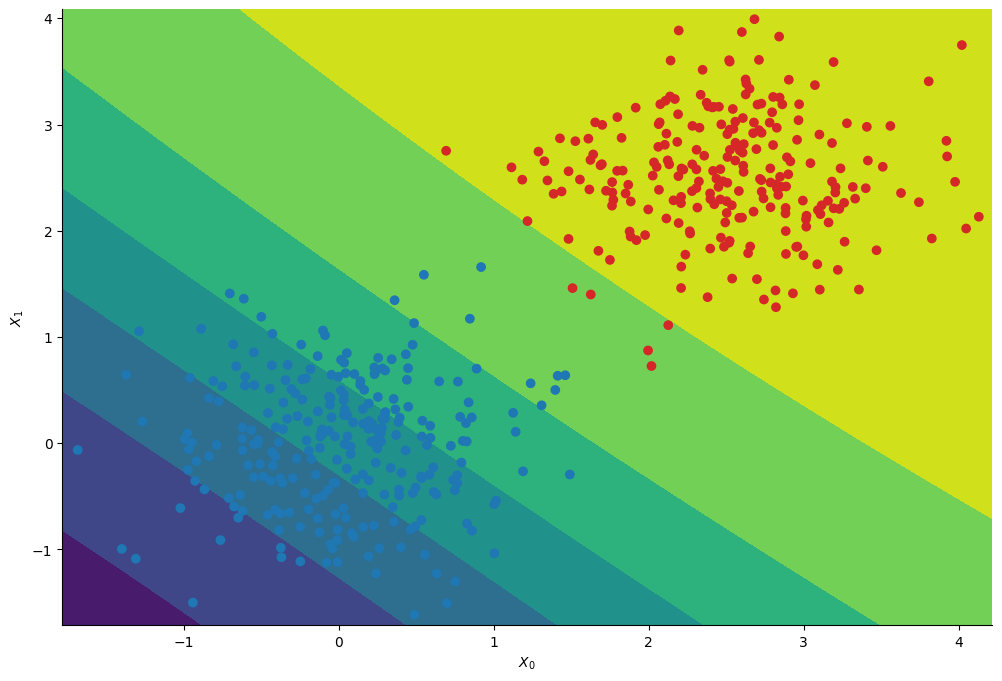

In [69]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.nn as nn
import jax.random as rdm
import jax.scipy.stats as stats
import blackjax

from sklearn.datasets import make_biclusters


seed = 0
rng_key = rdm.key(seed)

# generate data
N, P = 500, 2
X, rows, cols = make_biclusters(
    (N, P), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]

# 1. set up density
prior_var_b = 0.1
def logprob(beta):
  log_prior = jnp.sum(stats.norm.logpdf(beta, scale=jnp.sqrt(prior_var_b)))
  pi = nn.sigmoid(X @ beta)
  log_like = jnp.sum(stats.bernoulli.logpmf(y, pi))
  return log_like + log_prior

# 2. Set up HMC kernel (identity mass)
step_size = 0.01
num_steps = 500
Minv = jnp.eye(P) * jnp.reciprocal(prior_var_b)

nuts = blackjax.nuts(logprob, step_size, Minv)

# 3. Initialize

init_position = jnp.zeros((P,))
state = nuts.init(init_position)

# 4. Run a chain
@jax.jit
def one_step(state, key):
    key, subkey = jax.random.split(key)
    state, info = nuts.step(subkey, state)
    return state, (state.position, info.acceptance_rate)

num_samples = 5_000
keys = jax.random.split(key, num_samples)
states, (positions, accept_rate) = jax.lax.scan(one_step, state, keys)

positions = jnp.stack(positions)  # shape (num_samples, 2)
accept_rate = accept_rate.mean()

print("Acceptance rate:", accept_rate)

fig, ax = plt.subplots(1, 2, figsize=(12, 2))
for j, axi in enumerate(ax):
    axi.plot(positions[..., j])
    axi.set_title(f"$beta_{j}$")
plt.show()

# Create a meshgrid
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

# Compute the average probability to belong to the first cluster at each point on the meshgrid
print(Xspace.shape)
print(positions.shape)
Z_mcmc = nn.sigmoid(jnp.einsum("mij,sm->sij", Xspace, positions))
Z_mcmc = Z_mcmc.mean(axis=0)
plt.contourf(*Xspace, Z_mcmc)
plt.scatter(*X.T, c=colors)
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");